### 2.2 CNN Models - Test Cases

The trained CNN model was performed to a hold-out test set with 10,873 images.

The network obtained 0.743 and 0.997 AUC-PRC on the hold-out test set for cored plaque and diffuse plaque respectively.

In [1]:
import time, os

import torch
torch.manual_seed(42)
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
CSV_DIR = "data/tiles/CSV/rebalanced_hold-out.csv"

MODEL_DIR = "models/ResNet34_final.pkl" # Change this to the model you want to test.

IMG_DIR = "data/tiles/all_data/"
SAVE_DIR = 'data/outputs/'

In [3]:
if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)

In [4]:
batch_size = 32
num_workers = 24

norm = np.load('utils/normalization.npy', allow_pickle=True).item()

In [5]:
from torch.utils.data import Dataset
from PIL import Image

class MultilabelDataset(Dataset):
    def __init__(self, csv_path, img_path, transform=None):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data_info = pd.read_csv(csv_path)
        self.img_path = img_path
        self.transform = transform
        c=torch.Tensor(self.data_info.loc[:,'cored'])
        d=torch.Tensor(self.data_info.loc[:,'diffuse'])
        a=torch.Tensor(self.data_info.loc[:,'CAA'])
        c=c.view(c.shape[0],1)
        d=d.view(d.shape[0],1)
        a=a.view(a.shape[0],1)
        self.raw_labels = torch.cat([c,d,a], dim=1)
        self.labels = (torch.cat([c,d,a], dim=1)>0.99).type(torch.FloatTensor)

    def __getitem__(self, index):
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.labels[index]
        raw_label = self.raw_labels[index]
        # Get image name from the pandas df
        single_image_name = str(self.data_info.loc[index,'imagename'])
        # Open image
        try:
            img_as_img = Image.open(self.img_path + single_image_name)
        except:
            print("Get negative (Unused).")
            # img_as_img = Image.open(NEGATIVE_DIR + single_image_name)
        # Transform image to tensor
        if self.transform is not None:
            img_as_img = self.transform(img_as_img)
        # Return image and the label
        return (img_as_img, single_image_label, raw_label, single_image_name)

    def __len__(self):
        return len(self.data_info.index)

In [6]:
data_transforms = {
    'test'   : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(norm['mean'], norm['std'])
    ])
        }

image_datasets = {'test': MultilabelDataset(CSV_DIR, IMG_DIR, 
                                               data_transforms['test'])}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=num_workers)
               for x in ['test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}

image_classes = ['cored','diffuse','CAA']

use_gpu = torch.cuda.is_available()

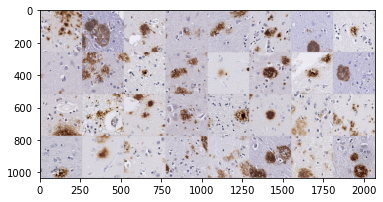

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(norm['mean'])
    std = np.array(norm['std'])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure()
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, labels, raw_labels, names = next(iter(dataloaders['test']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)

In [8]:
class Net(nn.Module):

    def __init__(self, fc_nodes=512, num_classes=3, dropout=0.5):
        super(Net, self).__init__()

    def forward(self, x):
 
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [9]:
def dev_model(model, criterion, phase='test', gpu_id=None):
    phase = phase
    since = time.time()
    
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers)
              for x in [phase]}

    model.train(False) 

    running_loss = 0.0
    running_corrects = torch.zeros(len(image_classes))
    running_preds = torch.Tensor(0)
    running_predictions = torch.Tensor(0)
    running_labels = torch.Tensor(0)
    running_raw_labels = torch.Tensor(0)

    # Iterate over data.
    step = 0
    for data in dataloaders[phase]:
        step += 1 
        # get the inputs
        inputs, labels, raw_labels, names = data
        running_labels = torch.cat([running_labels, labels])
        running_raw_labels = torch.cat([running_raw_labels, raw_labels])

        # wrap them in Variable
        if use_gpu:
            inputs = Variable(inputs.cuda(gpu_id))
            labels = Variable(labels.cuda(gpu_id))
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        # forward
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) #posibility for each class
        # print(preds)
        if use_gpu:
            predictions = (preds>0.5).type(torch.cuda.FloatTensor)
        else:
            predictions = (preds>0.5).type(torch.FloatTensor)
        
        loss = criterion(outputs, labels)

        preds = preds.data.cpu()
        predictions = predictions.data.cpu()
        labels = labels.data.cpu()

        # statistics
        running_loss += loss.item()
        running_corrects += torch.sum(predictions==labels, 0).type(torch.FloatTensor)
        running_preds = torch.cat([running_preds, preds])
        running_predictions = torch.cat([running_predictions, predictions])


    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects / dataset_sizes[phase]

    print('{} Loss: {:.4f}\n Cored: {:.4f} Diffuse: {:.4f} CAA: {:.4f}'.format(
                phase, epoch_loss, epoch_acc[0], epoch_acc[1], epoch_acc[2]))

    print()

    time_elapsed = time.time() - since
    print('Prediction complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return epoch_acc, running_preds, running_predictions, running_labels

In [10]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_roc(preds, label, image_classes, size=20, path=None):
    colors = ['pink','c','deeppink', 'b', 'g', 'm', 'y', 'r', 'k']
    fig = plt.figure(figsize=(1.2*size, size))
    ax = plt.axes()
    for i in range(preds.shape[1]):
        fpr, tpr, _ = roc_curve(label[:,i].ravel(), preds[:,i].ravel())
        lw = 0.2*size
        # Plot all ROC curves
        ax.plot([0, 1], [0, 1], 'k--', lw=lw, label='random')
        ax.plot(fpr, tpr,
                 label='ROC-curve of {}'.format(image_classes[i])+ '( area = {0:0.3f})'
                ''.format(auc(fpr, tpr)),
                  color=colors[(i+preds.shape[1])%len(colors)], linewidth=lw)
       
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=1.8*size)
    ax.set_ylabel('True Positive Rate', fontsize=1.8*size)
    ax.set_title('Receiver operating characteristic Curve', fontsize=1.8*size, y=1.01)
    ax.legend(loc=0, fontsize=1.5*size)
    ax.xaxis.set_tick_params(labelsize=1.6*size, size=size/2, width=0.2*size)
    ax.yaxis.set_tick_params(labelsize=1.6*size, size=size/2, width=0.2*size)
    
    if path != None:
        fig.savefig(path)
#         plt.close(fig)
        print('saved')

    
def plot_prc(preds, label, image_classes, size=20, path=None):
    colors = ['pink','c','deeppink', 'b', 'g', 'm', 'y', 'r', 'k']
    
    fig = plt.figure(figsize=(1.2*size,size))
    ax = plt.axes()
    
    for i in range(preds.shape[1]):
        rp = (label[:,i]>0).sum()/len(label)
        precision, recall, _ = precision_recall_curve(label[:,i].ravel(), preds[:,i].ravel())
        
        lw=0.2*size
    
        ax.plot(recall, precision,
                 label='PR-curve of {}'.format(image_classes[i])+ '( area = {0:0.3f})'
                ''.format(auc(recall, precision)),
                 color=colors[(i+preds.shape[1])%len(colors)], linewidth=lw)

        ax.plot([0, 1], [rp, rp], 'k--', color=colors[(i+preds.shape[1])%len(colors)], lw=lw, label='random')
   
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall', fontsize=1.8*size)
    ax.set_ylabel('Precision', fontsize=1.8*size)
    ax.set_title('Precision-Recall curve', fontsize=1.8*size, y=1.01)
    ax.legend(loc="lower left", bbox_to_anchor=(0.01, 0.1), fontsize=1.5*size)
    ax.xaxis.set_tick_params(labelsize=1.6*size, size=size/2, width=0.2*size)
    ax.yaxis.set_tick_params(labelsize=1.6*size, size=size/2, width=0.2*size)
    
    if path != None:
        fig.savefig(path)
#         plt.close(fig)
        print('saved')

In [11]:
def auc_roc(preds, label):
    aucroc = []
    for i in range(preds.shape[1]):
        fpr, tpr, _ = roc_curve(label[:,i].ravel(), preds[:,i].ravel())
        aucroc.append(auc(fpr, tpr))
    return aucroc
    
def auc_prc(preds, label):
    aucprc = []
    for i in range(preds.shape[1]):
        precision, recall, _ = precision_recall_curve(label[:,i].ravel(), preds[:,i].ravel())
        aucprc.append(auc(recall, precision))
    return aucprc

In [12]:
criterion = nn.MultiLabelSoftMarginLoss(reduction='sum')
model = torch.load(MODEL_DIR, map_location=lambda storage, loc: storage)
if use_gpu:
    model = model.module.cuda()

In [13]:
# take 10s running on single GPU
try:
    acc, pred, prediction, target = dev_model(model.module, criterion, phase='test', gpu_id=None)
except:
    acc, pred, prediction, target = dev_model(model, criterion, phase='test', gpu_id=None)

test Loss: 0.1041
 Cored: 0.9329 Diffuse: 0.9475 CAA: 0.9910

Prediction complete in 0m 9s


In [14]:
label = target.numpy()
preds = pred.numpy()

output = {}
for i in range(3):
    fpr, tpr, _ = roc_curve(label[:,i].ravel(), preds[:,i].ravel())

    precision, recall, _ = precision_recall_curve(label[:,i].ravel(), preds[:,i].ravel())
    
    output['{} fpr'.format(image_classes[i])] = fpr
    output['{} tpr'.format(image_classes[i])] = tpr
    output['{} precision'.format(image_classes[i])] = precision
    output['{} recall'.format(image_classes[i])] = recall

outcsv = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in output.items() ]))
outcsv.to_csv(SAVE_DIR+'CNN_test_output.csv', index=False)

/tmp/ipykernel_102654/2438910578.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 1], [rp, rp], 'k--', color=colors[(i+preds.shape[1])%len(colors)], lw=lw, label='random')
/tmp/ipykernel_102654/2438910578.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 1], [rp, rp], 'k--', color=colors[(i+preds.shape[1])%len(colors)], lw=lw, label='random')
/tmp/ipykernel_102654/2438910578.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 1], [rp, rp], 'k--', color=colors[(i+preds.shape[1])%len(colors)], lw=lw, label='random')


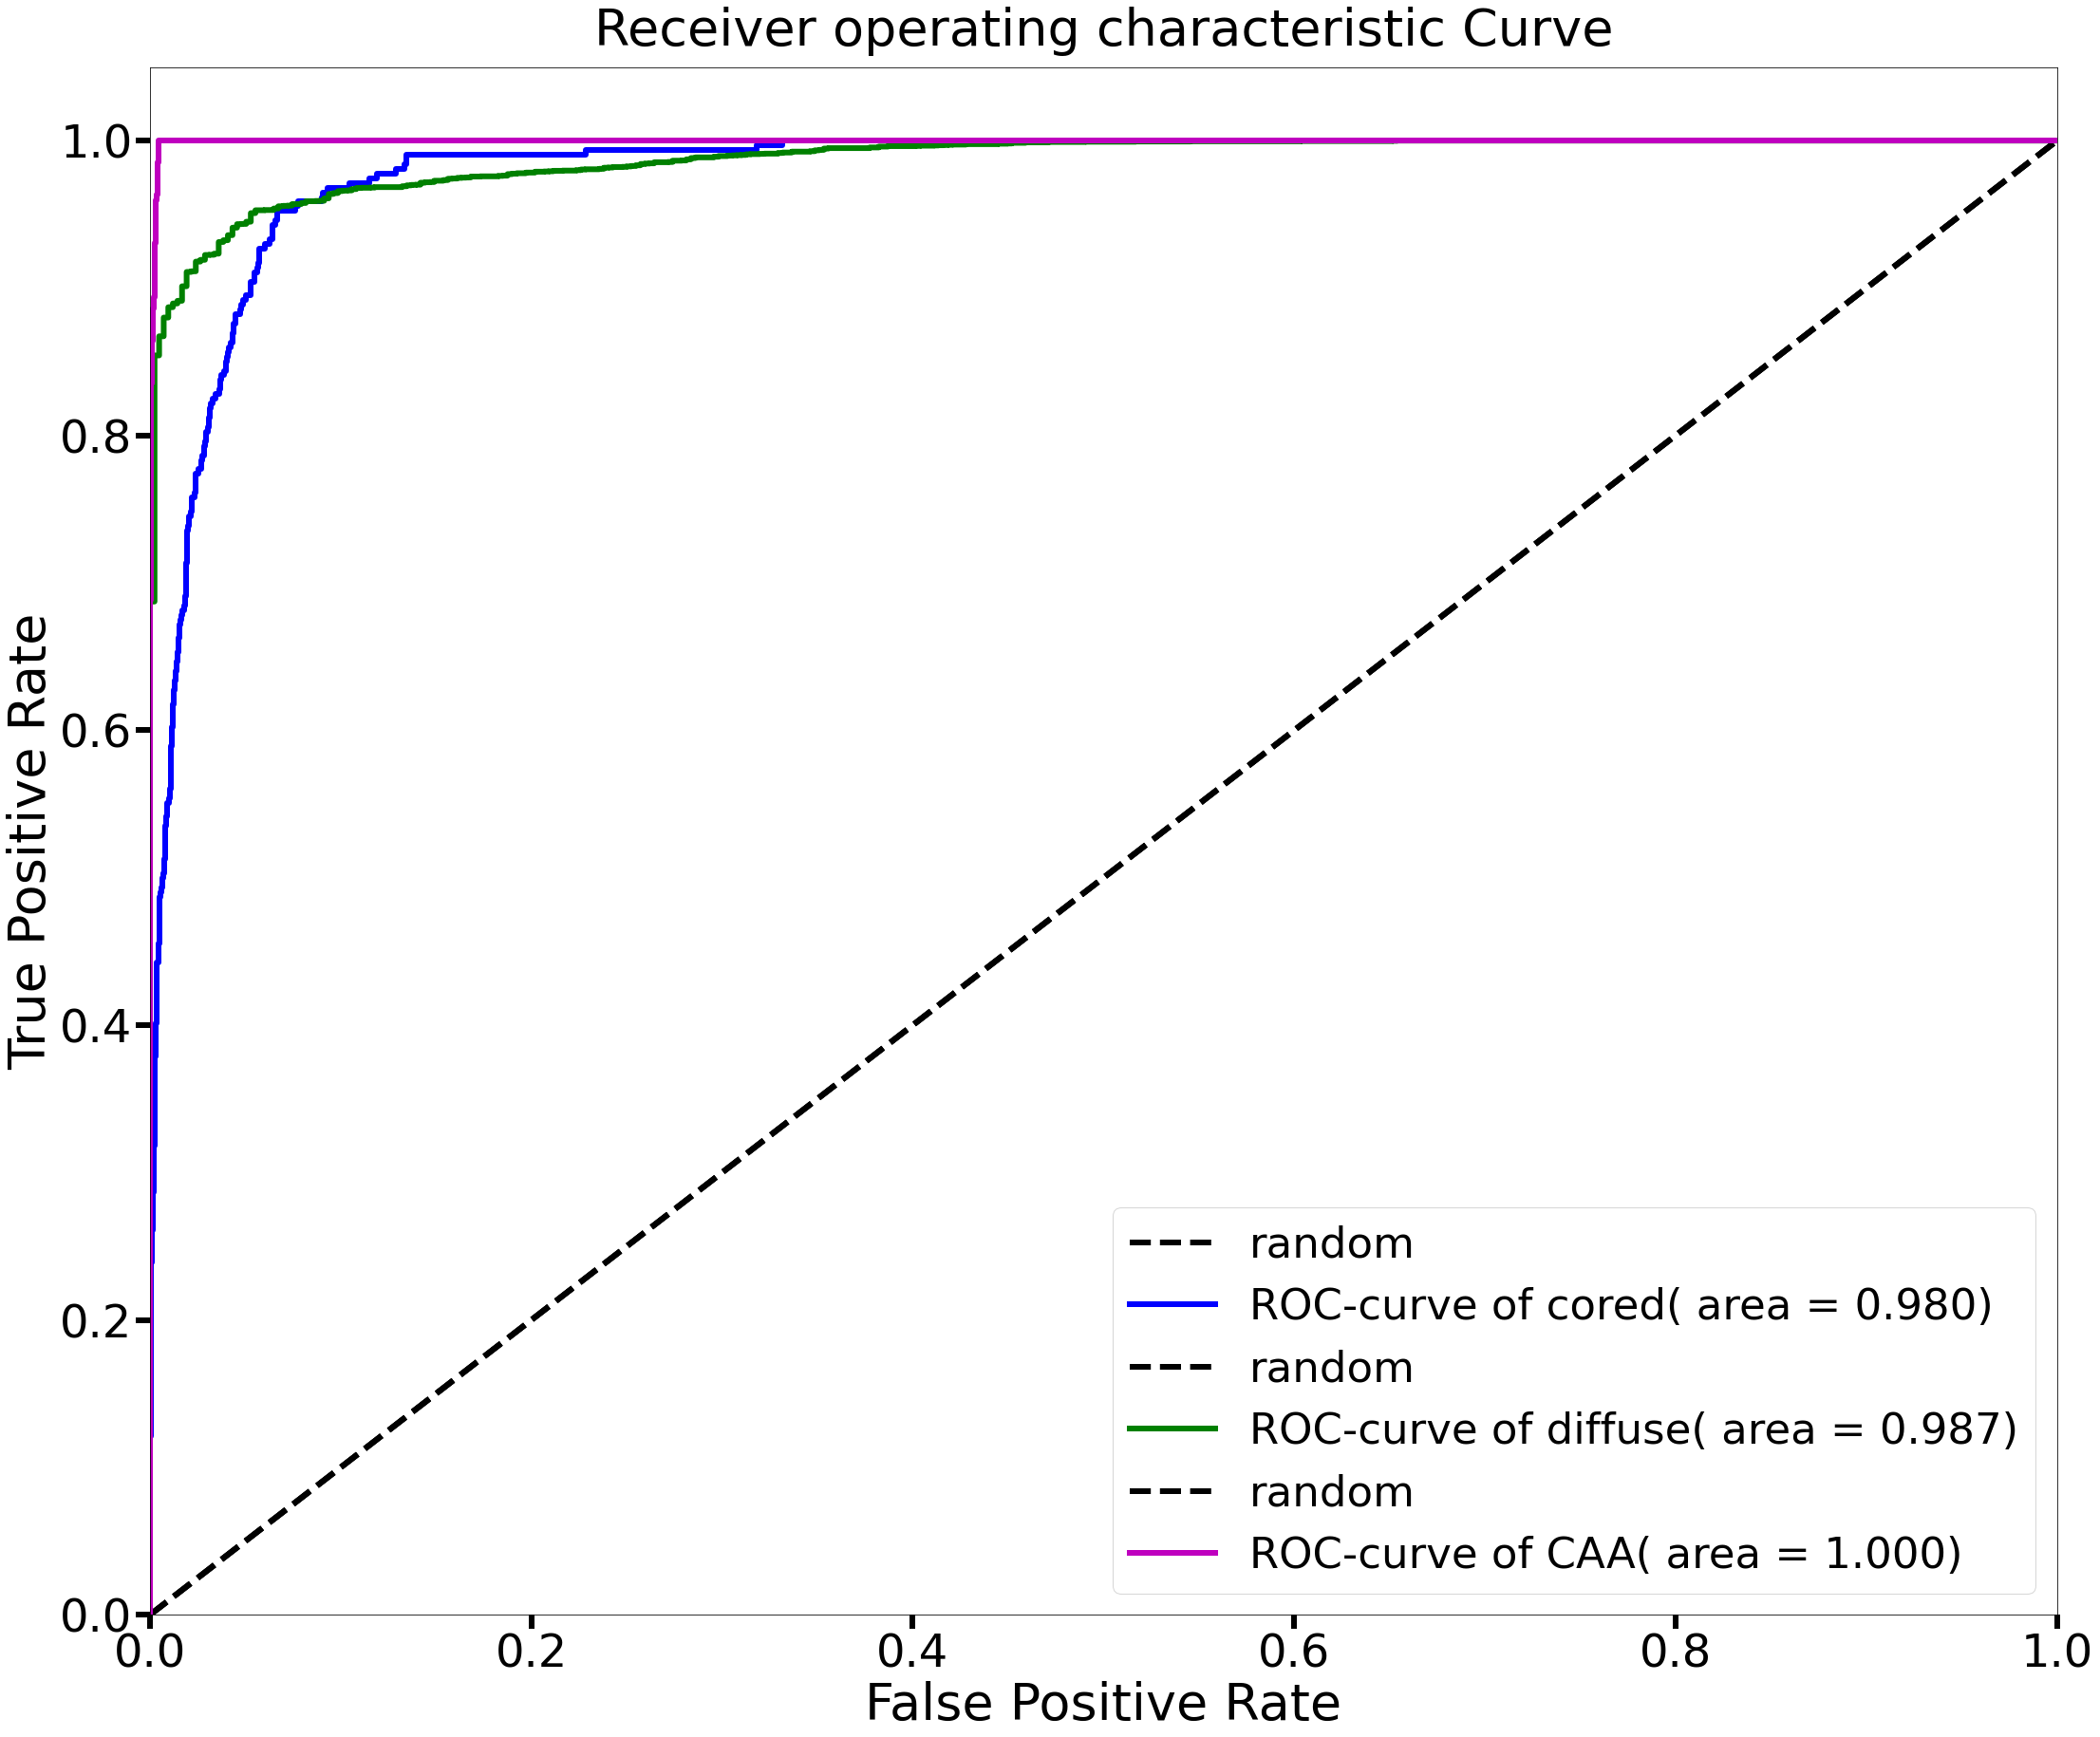

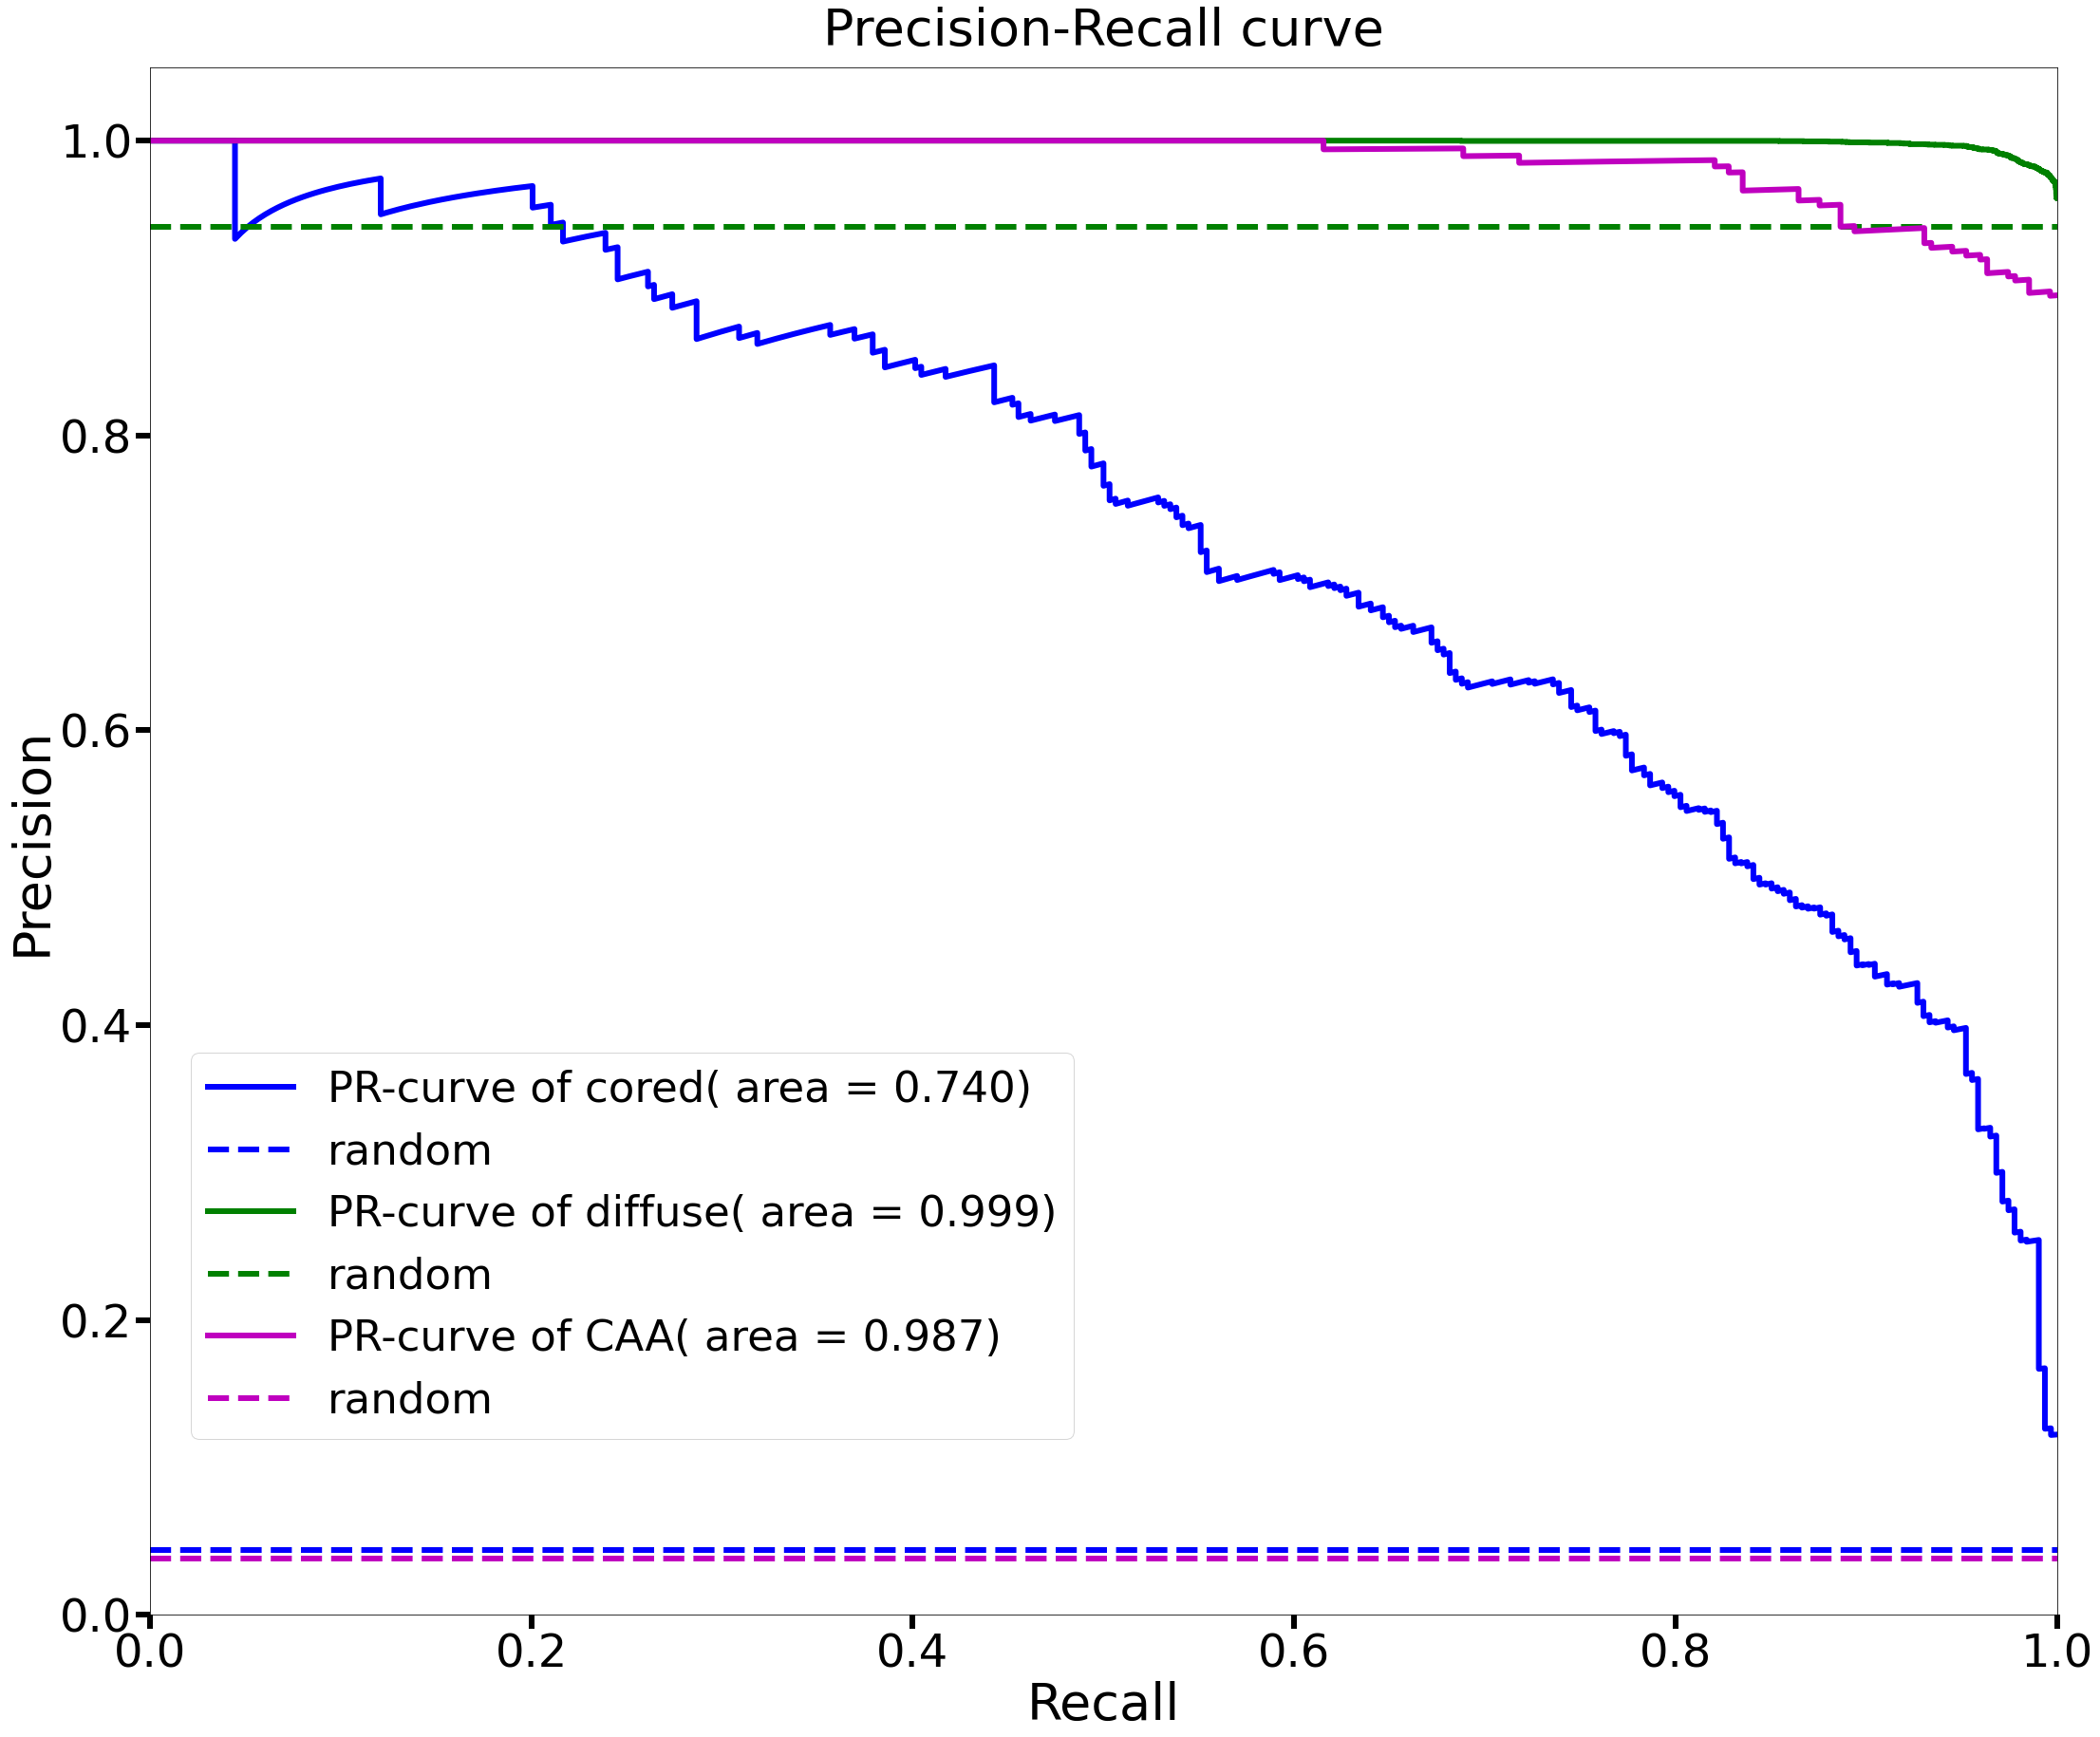

In [15]:
plot_roc(pred.numpy(), target.numpy(), image_classes, size=30)
plot_prc(pred.numpy(), target.numpy(), image_classes, size=30)